# Mean field VI code

Here, we code a mean-field variational approximation to discrete distributions.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys, time, pickle
import itertools

sys.path.insert(1, '../src/')
#from discrete_mixflows import *
#from gibbs import *
from concrete import *
from aux import LogSumExp

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})
#fig_path='fig/'
#fig_path='../../../discrete-ergodic-flows-tex/fig/'

In [2]:
########################
########################
#    mean field 1D     #
########################
########################
def meanfield1D(lq0,lp,max_iters,gamma):
    """
    Discrete mean field VI for 1D distributions
    
    Inputs:
        lq0       : (K,) array, initial variational log probabilities
        lp        : (K,) array, target log probabilities
        max_iters : int, max number of gradient ascent iterations
        gamma     : function, step size (as function)
    """
    q=np.exp(lq0)
    for t in range(max_iters): q=q-gamma(t)*(np.log(q)-lp)
    return np.log(q)

In [3]:
########################
########################
#    mean field 2D     #
########################
########################
def meanfield2D(lq1,lq2,lp,max_iters):
    """
    Discrete mean field VI for 2D distributions
    
    Inputs:
        lq1       : (K1,) array, initial variational log probabilities of X1
        lq2       : (K2,) array, initial variational log probabilities of X2
        lp        : (K1,K2) array, target log probabilities
        max_iters : int, max number of gradient ascent iterations
        
    Outputs:
        lq1_ : (K1,) array, updated X1 variational log probabilities
        lq2_ : (K2,) array, updated X2 variational log probabilities
    """
    
    lq1_=np.copy(lq1)
    lq2_=np.copy(lq2)
    for t in range(max_iters):
        # update q1
        lq1_=np.sum(np.exp(lq2_)[np.newaxis,:]*lp,axis=1)
        lq1_=lq1_-LogSumExp(lq1_[:,np.newaxis]) # normalizing constant
        
        # update q2
        lq2_=np.sum(np.exp(lq1_)[:,np.newaxis]*lp,axis=0)
        lq2_=lq2_-LogSumExp(lq2_[:,np.newaxis]) # normalizing constant
    # end for
    return lq1_,lq2_

In [4]:
########################
########################
#   mean field ising   #
########################
########################
def meanfieldIsing(M,beta,max_iters):
    """
    Discrete mean field VI for the Ising model
    Warning: only use for M<10
    
    Inputs:
        M         : int, number of particles
        beta      : float, inverse temperature (beta>0)
        max_iters : int, max number of gradient ascent iterations
        
    Outputs:
        lq        : (M,2) array, variational log pmf of each q_m
    """
    
    lq=-np.log(2)*np.ones((M,2)) # initialize at exactly 1/2 each
    for t in range(max_iters):
        for m in range(M):
            # edge cases first
            if m==0: tmplq1=beta*(2*lq[m+1,0]-1) # P(Xm=+1)+c
            if m==M-1: tmplq1=beta*(2*lq[m-1,0]-1) # P(Xm=+1)+c
            
            # non-edge cases now
            if m>0 and m<M-1: tmplq1=2*beta*(lq[m-1,0]+lq[m+1,0]-1) # P(Xm=+1)+c
            tmplq=np.array([-1.*tmplq1,tmplq1]) # (P(Xm=-1),P(Xm=+1))+c
            lZ=LogSumExp(tmplq[:,np.newaxis]) 
            lq[m,:]=tmplq-lZ
        # end for
    # end for
    
    return lq

def flattenlq(lq):
    M=lq.shape[0]
    tmpx=idx_unflattenBinary(np.arange(2**M),M)
    lq_flat=np.zeros(2**M)
    for i in range(2**M): lq_flat[i]=np.sum(lq[np.arange(M),tmpx[:,i]])
    return lq_flat

In [5]:
########################
########################
#    mean field gmm    #
########################
########################
from scipy.special import digamma as psi
def meanfieldGMM(y,mu0,sigma0,iterations):
    """
    Mean field VI for a Gaussian Mixture Model.
    The algorithm learns q(x,w,mus,Sigmas)
    where x are cluster labels, w are cluster weights,
    mus are cluster means, and Sigmas are cluster covariances.
    The variational approximation decomposes as:
    q(x_n)~Cat(r_{n,1:K}),
    q(w)~Dir(alphas),
    q(Sigma_k)~InvWishart(invW_k,nu_k),
    q(mu_k|Sigma_k)~N(m_k,Sigma_k/beta_k)).
    
    Inputs:
        y          : (N,D) array, observations (N is no. of obs, d is dimension of each obs)
        mu0        : (K,D) array, initial means (K is number of clusters)
        sigma0     : (K,D,D) array, initial covariances
        iterations : int, number of iterations to run optimization for
        
    Outputs:
        alphas     : (K,) array, weights Dirichlet approximation variational parameters
        lrs        : (N,K) array, estimated cluster probabilities per observation
        ms         : (K,D) array, means mean variational parameters
        betas      : (K,) array, means covariance variational parameters
        invWs      : (K,D,D) array, covariance invWishart variational parameters
        nus        : (K,) array, covariance invWishart degrees of freedom
    """
    N,D=y.shape
    K=mu0.shape[0]
    
    # init params
    alpha0=1. # weights w Dirichlet prior param, small = let the data speak
    beta0=0.1*N  # means precision. Default: prior sample size = 10% of observed sample size
    nu0=1.#N-D-2
    
    # init arrays
    lrs=np.zeros((N,K))-np.log(K) # init at unif
    alphas=np.zeros(K)
    betas=np.zeros(K)
    logLs=np.zeros(K)
    logws=np.zeros(K)
    ms=np.zeros((K,D))
    Ws=np.ones((K,D,D))
    logdetWs=np.zeros(K)
    invWs=np.ones((K,D,D))
    nus=np.ones(K)
    
    for t in range(iterations):
        print('Iter '+str(t+1)+'/'+str(iterations),end='\r')
        Nks=np.sum(np.exp(lrs),axis=0)
        
        
        # variational M
        for k in range(K):
            # get summary statistics
            Nk=Nks[k]
            yk=np.sum(np.exp(lrs[:,k]).reshape(N,1)*y,axis=0)/Nk
            Sk=np.sum(np.exp(lrs[:,k]).reshape(N,1,1)*(y.reshape(N,D,1)-yk.reshape(1,D,1))*(y.reshape(N,1,D)-yk.reshape(1,1,D)),axis=0)/Nk
            
            # update Dirichlet params
            alphas[k]=alpha0+Nk
            
            # update mean params
            betas[k]=beta0+Nk
            ms[k,:]=(beta0*mu0[k,:]+Nk*yk)/betas[k]
            
            # update cov params
            invWs[k,:,:]=sigma0[k,:,:]+Nk*Sk+beta0*Nk/(beta0+Nk)*(yk-mu0[k,:])[:,np.newaxis]*(yk-mu0[k,:])[np.newaxis,:]
            Ws[k,:,:]=np.linalg.inv(invWs[k])
            nus[k]=nu0+Nk
            
            # define aux quantities
            sign,logdetinvWk = np.linalg.slogdet(invWs[k,:,:])
            logdetWs[k]=-logdetinvWk
            logLs[k]=np.sum(psi(0.5*(nus[k]+1-np.arange(1,D+1))))+D*np.log(2)+logdetWs[k]
            logws[k]=psi(alphas[k])+psi(np.sum(alphas))
            # end for
        
        # variational E
        for k in range(K):
            lrs[:,k]=logws[k]+0.5*logLs[k]-0.5*D/betas[k]
            gauss_term=0.5*nus[k]*np.sum(np.sum((y.reshape(N,D,1)-ms[k,:].reshape(1,D,1))*Ws[k]*(y.reshape(N,1,D)-ms[k,:].reshape(1,1,D)),axis=-1),axis=-1)
            lrs[:,k]-=gauss_term
        # end for
        
        # normalize weights
        lrs=lrs-LogSumExp(lrs.T)[:,np.newaxis]
    # end for
    
    return alphas,lrs,ms,betas,invWs,nus

## Mean field 1D

First we deal with the case when the target distribution is univariate.
In this setting,
we simply optimize the individual probabilities via gradient descent.

In [6]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=10
prbs=np.random.rand(K1)
prbs=prbs/np.sum(prbs)

In [7]:
########################
########################
#  fit mean field 1D   #
########################
########################
lq0=np.log(1/K1)*np.ones(K1)
lp=np.log(prbs)
max_iters=10000
ss=1e-2
gamma = lambda t : ss/np.sqrt(t+1)
mf_approx=np.exp(meanfield1D(lq0,lp,max_iters,gamma))

Text(0, 0.5, 'Probability')

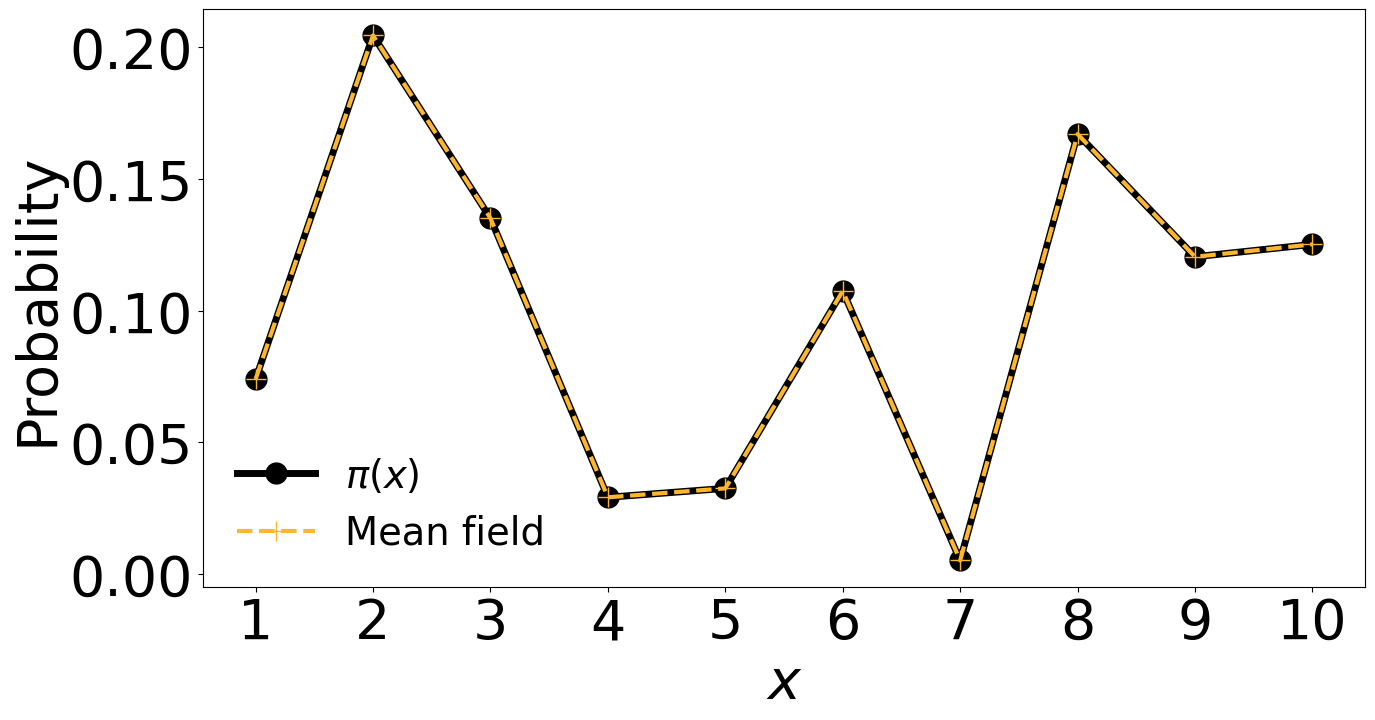

In [8]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,10)
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,mf_approx,c='#FEB72D', label='Mean field',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='x-small',frameon=False)
plt.xlabel(r'$x$')
plt.xticks(ticks=np.arange(0,10)+0.5,labels=np.arange(1,1+10))
plt.ylabel('Probability')

## Mean field 2D

Now we consider the case where we have a bivariate discrete target $\pi$.
We approximate $\pi$ with $q(x_1,x_2)=q_1(x_1) q_2(x_2)$,
where $q_m$ is a univariate approximation to the $m$th component of $\pi$, $i=1,2$.

We sequentially update the probabilities of $q_i$ via gradient ascent.
Specifically, we take $q_m$ to be a categorical distribution with probabilities
$(q_{mi})_{i=1}^{K_m}$ and sequentially update
$$
q_{1i}\gets\sum_{j=1}^{K_2} q_{2j}\log\pi(i,j),\quad
q_{2j}\gets\sum_{i=1}^{K_1} q_{i1}\log\pi(i,j).
$$
This update comes from updating each coordinate with the expectation w.r.t.
the other components of the log target density.

### Independent example

First we consider an example where the target has two independent components:
$\pi(i,j)=\pi_1(i)\pi_2(j)$.
In this case we expect the mean field approximation to recover the target.
We show both pmf plots at the end.

In [9]:
########################
########################
# target specification #
########################
########################
K1,K2=4,5
p1=np.random.rand(K1)
p1/=np.sum(p1)
p2=np.random.rand(K2)
p2/=np.sum(p2)
p=p1[:,np.newaxis]*p2[np.newaxis,:]
prbs_twodim=p/np.sum(p)
print(prbs_twodim)

[[0.07648782 0.03435237 0.07163065 0.03821968 0.08287098]
 [0.0840313  0.03774031 0.0786951  0.04198903 0.09104398]
 [0.06611264 0.02969264 0.06191432 0.03303538 0.07162995]
 [0.02533637 0.01137912 0.02372744 0.01266016 0.02745077]]


In [10]:
########################
########################
#  fit mean field 2D   #
########################
########################
lq1=np.log(1/K1)*np.ones(K1)
lq2=np.log(1/K2)*np.ones(K2)
lp=np.log(prbs_twodim)
max_iters=10
mf_approx1,mf_approx2=meanfield2D(lq1,lq2,lp,max_iters)

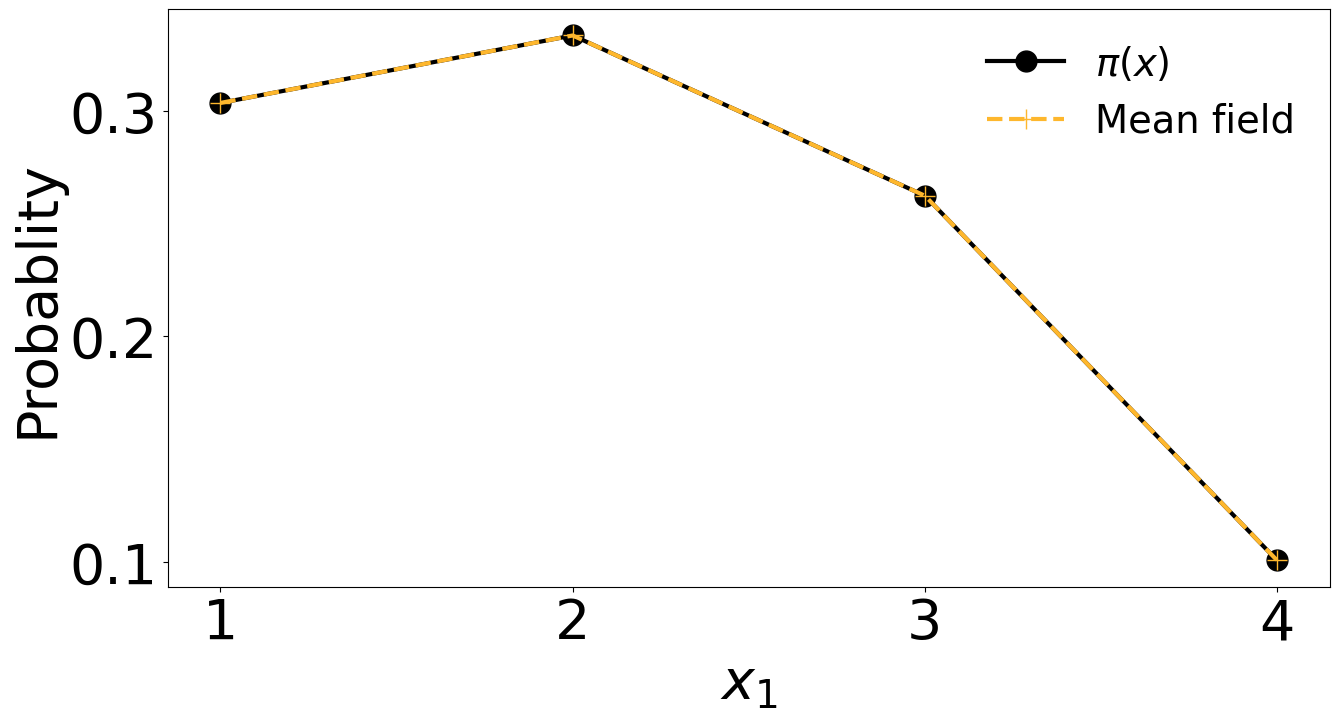

In [11]:
########################
########################
#   plot x1 results    #
########################
########################

ttx=np.arange(0,4)
plt.plot(ttx+0.5,np.sum(prbs_twodim,axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.exp(mf_approx1)/np.sum(np.exp(mf_approx1)),c='#FEB72D', label='Mean field',lw=3,ls='dashed',ms=15,marker='+')
plt.xlabel(r'$x_1$')
plt.ylabel('Probablity')
plt.xticks(ticks=np.arange(0,4)+0.5,labels=np.arange(1,1+K1))
plt.legend(fontsize='x-small',frameon=False)

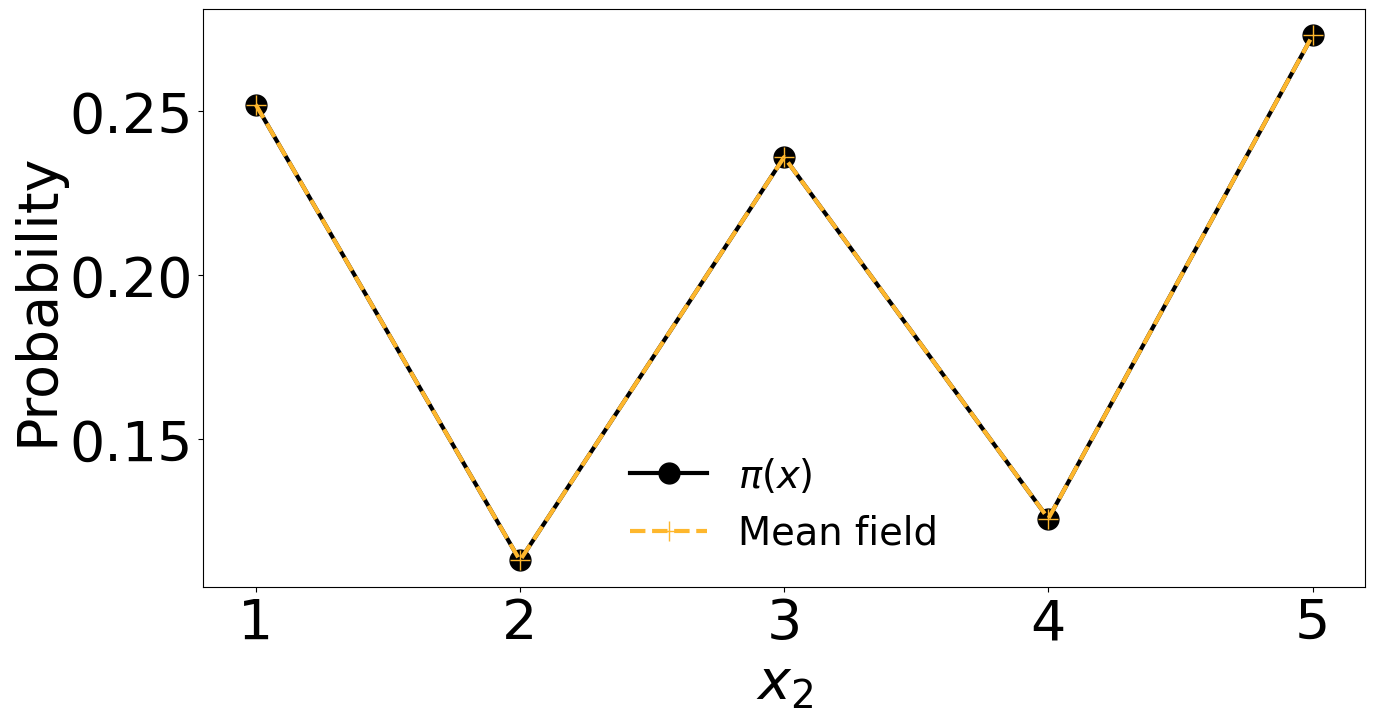

In [12]:
########################
########################
#   plot x2 results    #
########################
########################

ttx=np.arange(0,5)
plt.plot(ttx+0.5,np.sum(prbs_twodim,axis=0),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.exp(mf_approx2)/np.sum(np.exp(mf_approx2)),c='#FEB72D', label='Mean field',lw=3,ls='dashed',ms=15,marker='+')
plt.xlabel(r'$x_2$')
plt.xticks(ticks=np.arange(0,5)+0.5,labels=np.arange(1,1+K2))
plt.ylabel('Probability')
plt.legend(fontsize='x-small',frameon=False)

### Discrete 2D toy example

Now we approximate the distribution in the paper, which does not have independent components.

In [13]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=4
K2=5
prbs=np.random.rand(K1,K2)
prbs=prbs/np.sum(prbs)
prbs_twodim=np.copy(prbs)

In [14]:
########################
########################
#  fit mean field 2D   #
########################
########################
lq1=np.log(1/K1)*np.ones(K1)
lq2=np.log(1/K2)*np.ones(K2)
lp=np.log(prbs_twodim)
max_iters=10
mf_approx1,mf_approx2=meanfield2D(lq1,lq2,lp,max_iters)

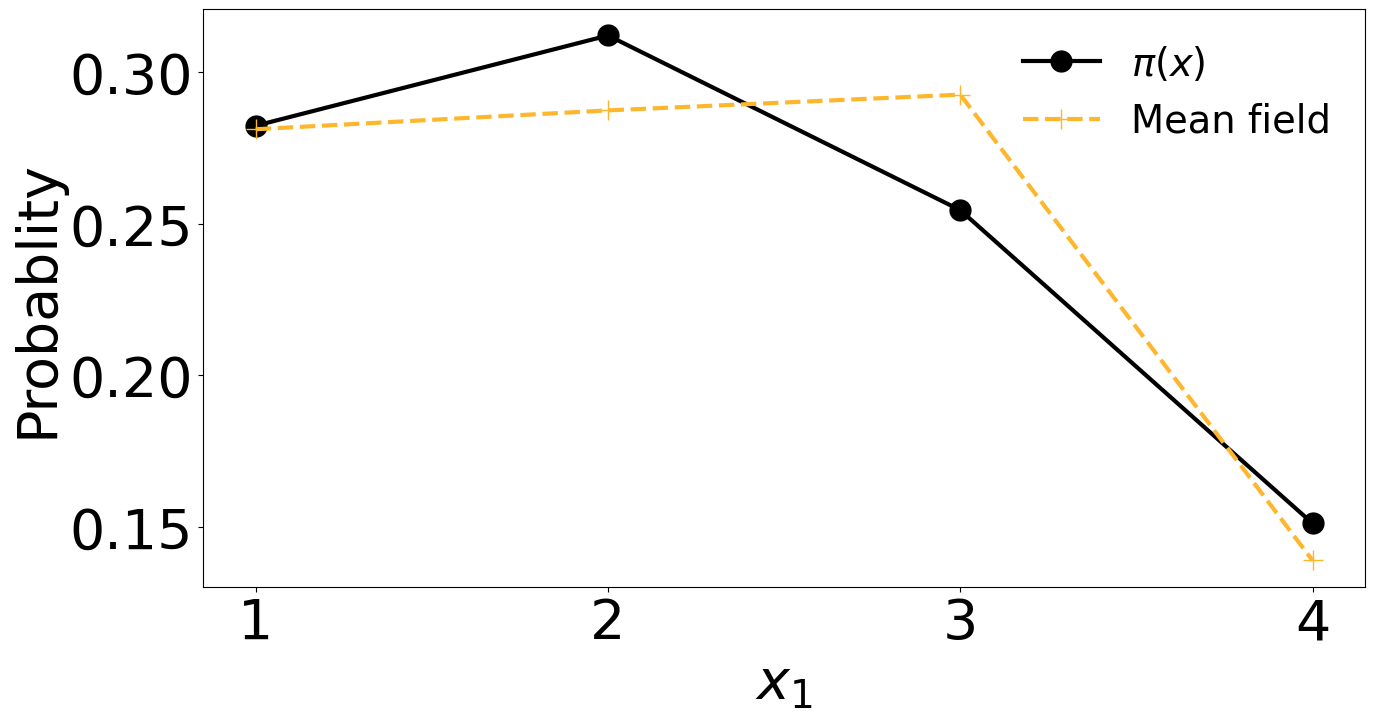

In [15]:
########################
########################
#   plot x1 results    #
########################
########################

ttx=np.arange(0,4)
plt.plot(ttx+0.5,np.sum(prbs_twodim,axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.exp(mf_approx1)/np.sum(np.exp(mf_approx1)),c='#FEB72D', label='Mean field',lw=3,ls='dashed',ms=15,marker='+')
plt.xlabel(r'$x_1$')
plt.ylabel('Probablity')
plt.xticks(ticks=np.arange(0,4)+0.5,labels=np.arange(1,1+K1))
plt.legend(fontsize='x-small',frameon=False)

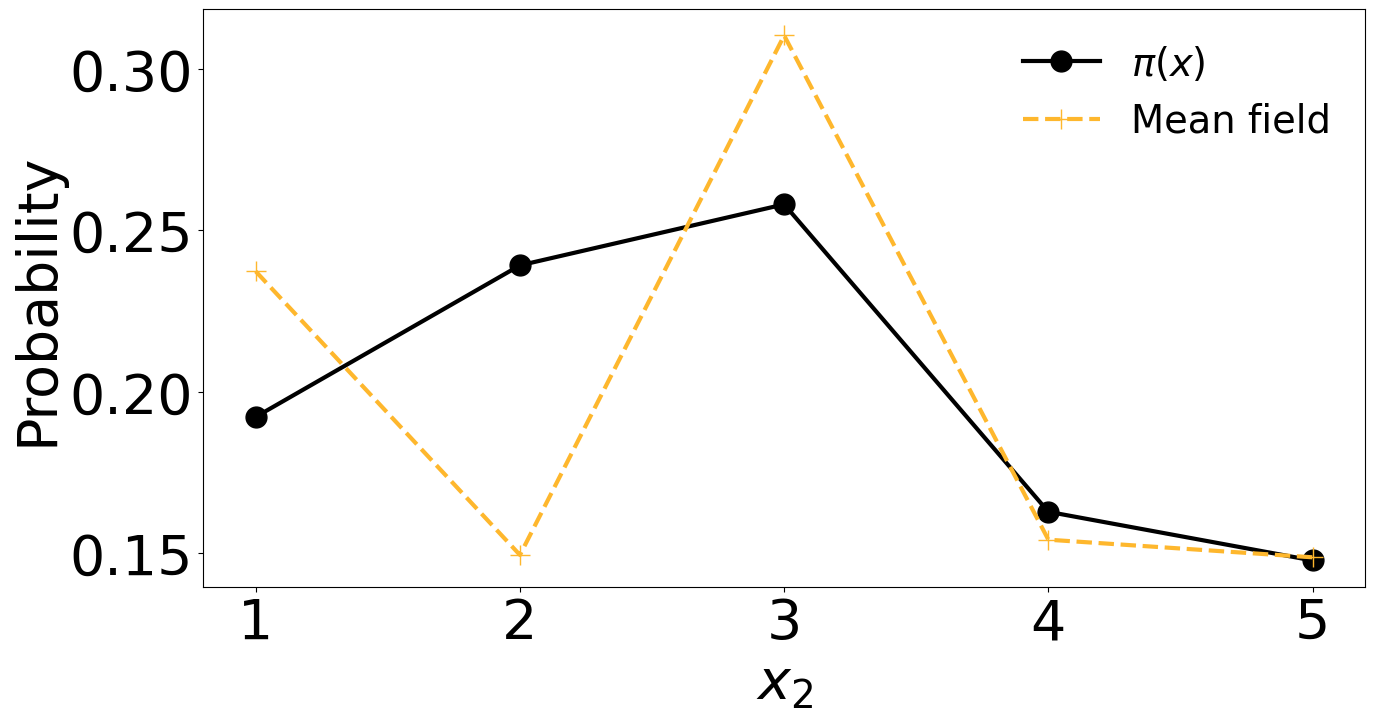

In [16]:
########################
########################
#   plot x2 results    #
########################
########################

ttx=np.arange(0,5)
plt.plot(ttx+0.5,np.sum(prbs_twodim,axis=0),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.exp(mf_approx2)/np.sum(np.exp(mf_approx2)),c='#FEB72D', label='Mean field',lw=3,ls='dashed',ms=15,marker='+')
plt.xlabel(r'$x_2$')
plt.xticks(ticks=np.arange(0,5)+0.5,labels=np.arange(1,1+K2))
plt.ylabel('Probability')
plt.legend(fontsize='x-small',frameon=False)

### Mean field mixture

Finally, we consider the 2D mixture from the paper.

In [17]:
########################
########################
# target specification #
########################
########################
mu=np.array([4,15]) # the two modes
K1,K2=20,2
def aux_gausslp(aux): return -0.5*(np.arange(0,20)-mu[aux][:,np.newaxis])**2-0.5*np.log(2*np.pi)
def aux_gausslp_1d(y,x): return -0.5*(y-mu[x])**2-0.5*np.log(2*np.pi)

def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    y=x[0,:]
    aux=x[1,:]
    
    if axis==None: return -0.5*(y-mu[aux])**2-0.5*np.log(2*np.pi)
    if axis==0: return aux_gausslp(aux)
    if axis==1: 
        wlpy0=aux_gausslp_1d(y,0)+np.log(0.5)
        wlpy1=aux_gausslp_1d(y,1)+np.log(0.5)
        m=np.maximum(wlpy0,wlpy1)
        lpy=m+np.log(np.exp(wlpy0-m)+np.exp(wlpy1-m))
        out=np.ones((y.shape[0],2))
        out[:,0]=wlpy0
        out[:,1]=wlpy1
        return out-lpy[:,np.newaxis]
    raise Exception("Axis out of bounds - there aren't that many variables")

In [18]:
# evaluate target density
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)

mylp=np.exp(lp(x))
prbs=np.zeros((20,2))
prbs[:,0]=mylp[:20]
prbs[:,1]=mylp[20:]
prbs=prbs/np.sum(prbs)
prbs_mixture=np.copy(prbs)

In [19]:
##########################
##########################
# fit mean field mixture #
##########################
##########################
lq1=np.log(1/K1)*np.ones(K1)
lq2=np.log(1/K2)*np.ones(K2)
lp=np.log(prbs_mixture)
max_iters=10000
mf_approx1,mf_approx2=meanfield2D(lq1,lq2,lp,max_iters)

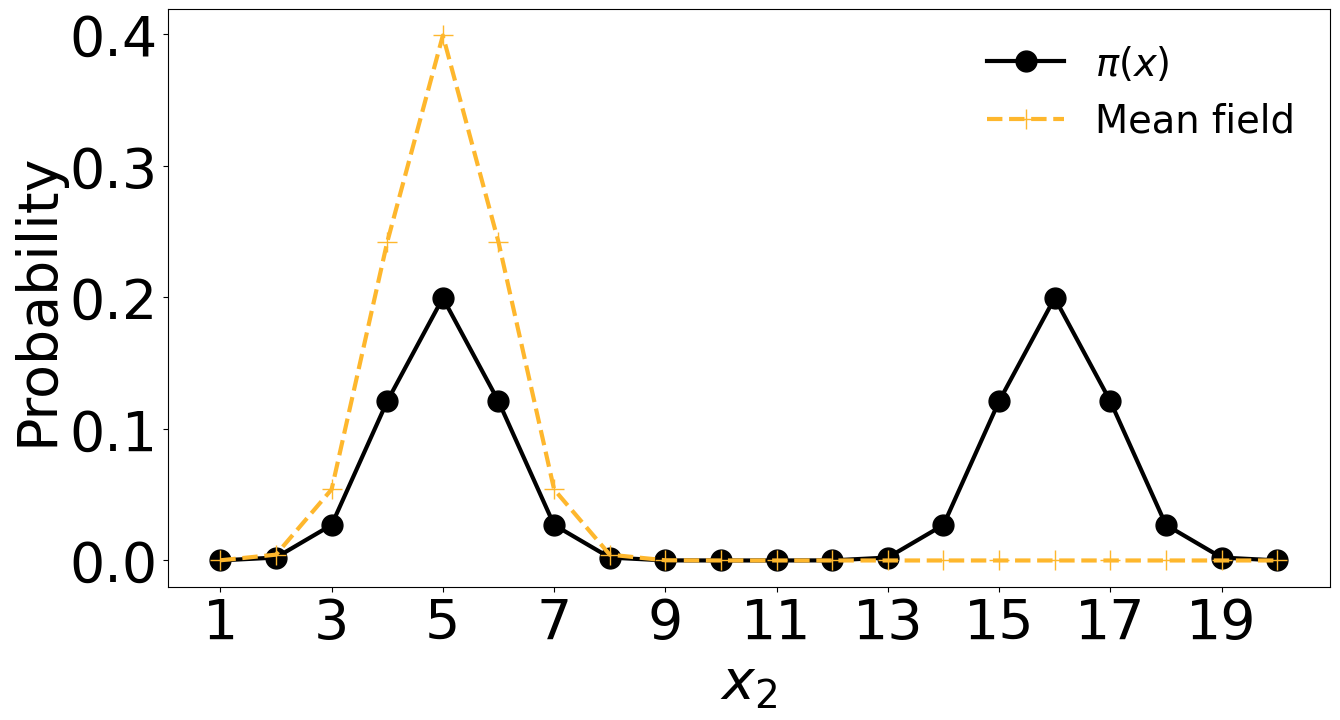

In [20]:
ttx=np.arange(0,20)
plt.plot(ttx+0.5,np.sum(prbs_mixture/np.sum(prbs_mixture),axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.exp(mf_approx1)/np.sum(np.exp(mf_approx1)),c='#FEB72D', 
         label='Mean field',lw=3,ls='dashed',ms=15,marker='+')
plt.xlabel(r'$x_2$')
plt.xticks(ticks=np.arange(0,20,step=2)+0.5,labels=np.arange(1,21,step=2))
plt.ylabel('Probability')
plt.legend(fontsize='x-small',frameon=False)

## Ising low M

In [21]:
########################
########################
# target specification #
########################
########################
M=5 # number of particles

# target
beta=1. # inverse temperature
logZ1=np.log(2*np.cosh(beta)) # same for any value of x_2 and x_(M-1)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs of the Ising model
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,2) array with d conditionals 
    
    xc=np.copy(x)
    xc[xc==0]=-1 # internally lowest x=0, but here we need lowest x=-1
    if axis==None: 
        tmp_x=np.vstack((np.zeros((1,xc.shape[1])),np.copy(xc))) # add row with 0's at start of x
        lag_x=np.vstack((np.copy(xc),np.zeros((1,xc.shape[1])))) # add row with 0's at end of x
        return beta*np.sum(tmp_x*lag_x,axis=0)
    if axis==0: return np.vstack((-xc[1,:],xc[1,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis+1,:]))
    if axis==M-1: return np.vstack((-xc[-2,:],xc[-2,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis-1,:]))
    if axis>=M: raise Exception("Axis out of bounds")
    logZm=np.log(2*np.cosh(beta*(xc[axis-1,:]+xc[axis+1,:])))
    return np.vstack((-xc[axis-1,:]-xc[axis+1,:],xc[axis-1,:]+xc[axis+1,:])).T-logZm[:,np.newaxis]


x=idx_unflattenBinary(np.arange(0,2**M),M)
lprbs=lp(x)
prbs=np.exp(lprbs)
prbs=prbs/np.sum(prbs)

In [22]:
##########################
##########################
#  fit mean field ising  #
##########################
##########################
ising_lq=meanfieldIsing(M,beta,10000)
ising_q=np.exp(flattenlq(ising_lq))

Text(0, 0.5, 'Probability')

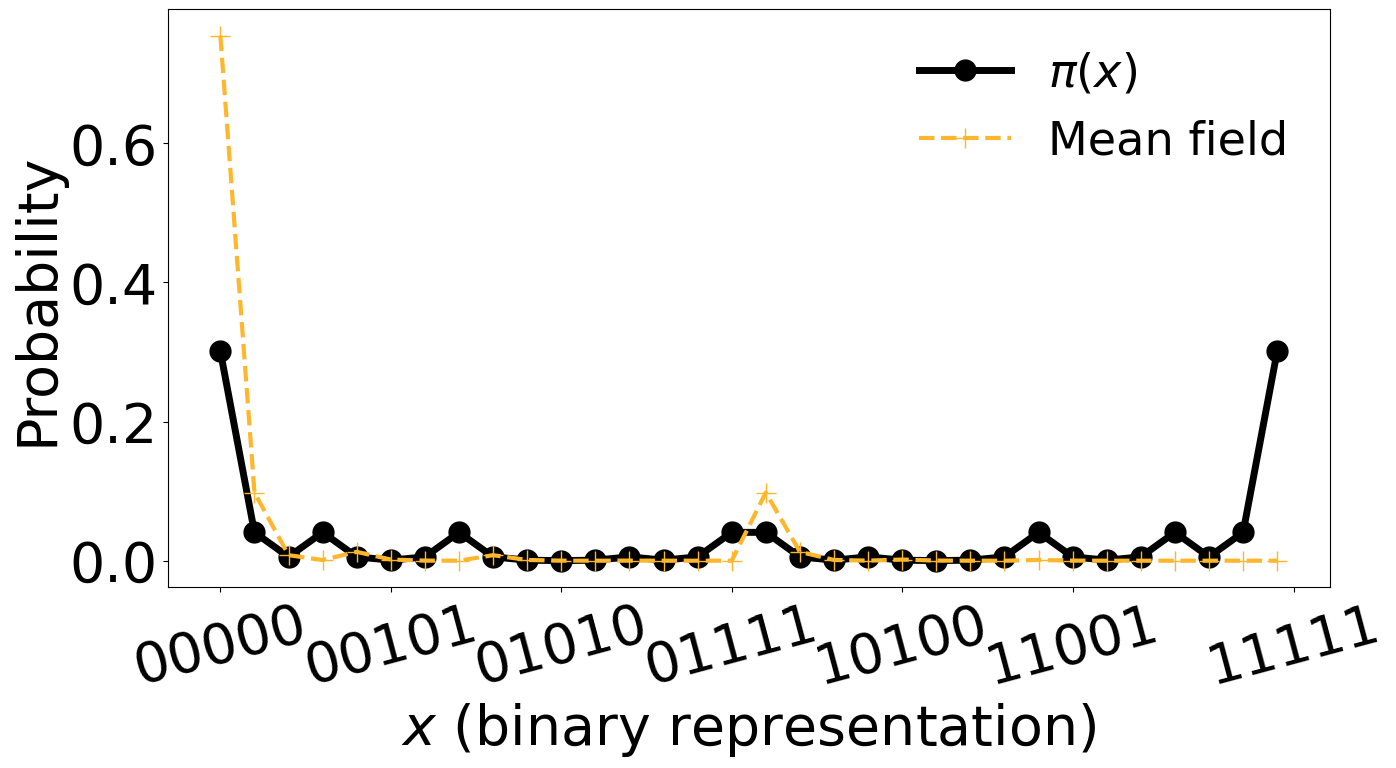

In [23]:
########################
########################
#     plot results     #
########################
########################
ticks=np.arange(0,2**M,step=M)+0.5
ticks[-1]=2**M

ttx=np.arange(0,2**M)
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,ising_q,c='#FEB72D', 
         label='Mean field',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='small',frameon=False)
plt.xlabel('$x$ (binary representation)')
plt.xticks(ticks=ticks,
           labels=[format(int(t), '05b') for t in ticks-0.5],
          rotation=15)
plt.ylabel('Probability')

## GMM

Taken from Pattern Recognition and Machine Learning by Bishop (2006), section 10.2.

**Model**:
- likelihood $\mathbb{R}^D\ni y_n\sim\sum_{k=1}^K w_k\phi_{\mu_k,\Sigma_k},\quad n=1,\dots,N$;
- labels $x_n\sim\mathrm{Cat}(r_{n1},\dots,r_{nK}),\quad n=1,\dots,N$;
- weights $w\sim\mathrm{Dir}(\alpha_1,\dots,\alpha_K)$;
- means $\mu_k\,|\,\Sigma_k\sim\mathcal{N}(m_k,\Sigma_k/\beta_k),\quad k=1,\dots,K$;
- covariances $\Sigma_k\sim\mathrm{IW}(W_k^{-1},\nu_k),\quad k=1,\dots,K$.

**Summary quantities**:
- $N_k=\sum_{n=1}^N r_{nk}$;
- $\bar{y}_k=N_k^{-1}\sum_{n=1}^N r_{nk}y_n$;
- $S_k=N_k^{-1}\sum_{n=1}^N r_{nk}(y_n-\bar{y}_k)(y_n-\bar{y}_k)^\top$

for $k=1,\dots,K$.

**Initial hyperparameters**:
- $\alpha_0$, impact of prior knowledge on weights; set to 1 to allow data to speak;
- $\beta_0$, prior sample size for mean estimation; set to 10\% of sample size, 0.1N;
- $m_0$, prior location of mean; eyeballed;
- $\nu_0$, prior sample size for covariance estimation; set to 1;
- $W_0^{-1}$, related to prior covariance. The prior expected covariance is $W_0^{-1}/\nu_0$.
Since we set $\nu_0=1$, we eyeball a conservative estimate of the empirical variance of each variable
and define $W_0^{-1}$ as a diagonal matrix with the eyeballed variances (no prior correlation).

Hyperparmeters can also depend on $k$ but we omit that for ease of presentation.

**Variational M**:
- $\alpha_k=\alpha_0+N_k$;
- $\beta_k=\beta_0+N_k$ (~posterior sample size);
- $m_k=(\beta_0 m_0 + N_k \bar{y}_k)/\beta_k$ (weighted average of means);
- $\nu_k=\nu_0+N_k$ (~posterior sample size);
- $W_k^{-1}=W_0^{-1}+N_k S_k + \frac{\beta_0 N_k}{\beta_0+N_k}(\bar{y}_k-m_0)(\bar{y}_k)-m_0)^\top$.

**Auxiliary quantities**:
- $\log\Lambda_k=\sum_{d=1}^D \psi\left(\frac{\nu_k+1-i}{2}\right)+D\log2-\log|W_k^{-1}|$;
- $\log w_k=\psi(\alpha_k)-\psi(\sum_k \alpha_k)$,

for $k=1,\dots,K$ and with $\psi$ the diggama function.

**Variational E**:
- $\log r_{nk}=\log w_k+\frac{1}{2}\log\Lambda_k-\frac{D}{2\beta_k}-\frac{1}{2}(y_n-m_k)^\top(W_k^{-1}/\nu_k)^{-1}(y_n-m_k)+C$.

### Old Faithful

In [24]:
####################
####################
#  data wrangling  #
####################
####################
of_dat=pd.read_table('https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv')
dat=np.array(of_dat)

In [25]:
####################
####################
#      setup       #
####################
####################
K=2
y=dat
mu0=np.array([[2,50],[5,80]])
sigma0=np.zeros((K,2,2))
for k in range(K): sigma0[k,:,:]=5.*np.eye(2)
iterations=10000

In [26]:
####################
####################
#  run optimizer   #
####################
####################
alphas,lrs,ms,betas,invWs,nus=meanfieldGMM(y,mu0,sigma0,iterations)

Text(0, 0.5, 'Wait time')

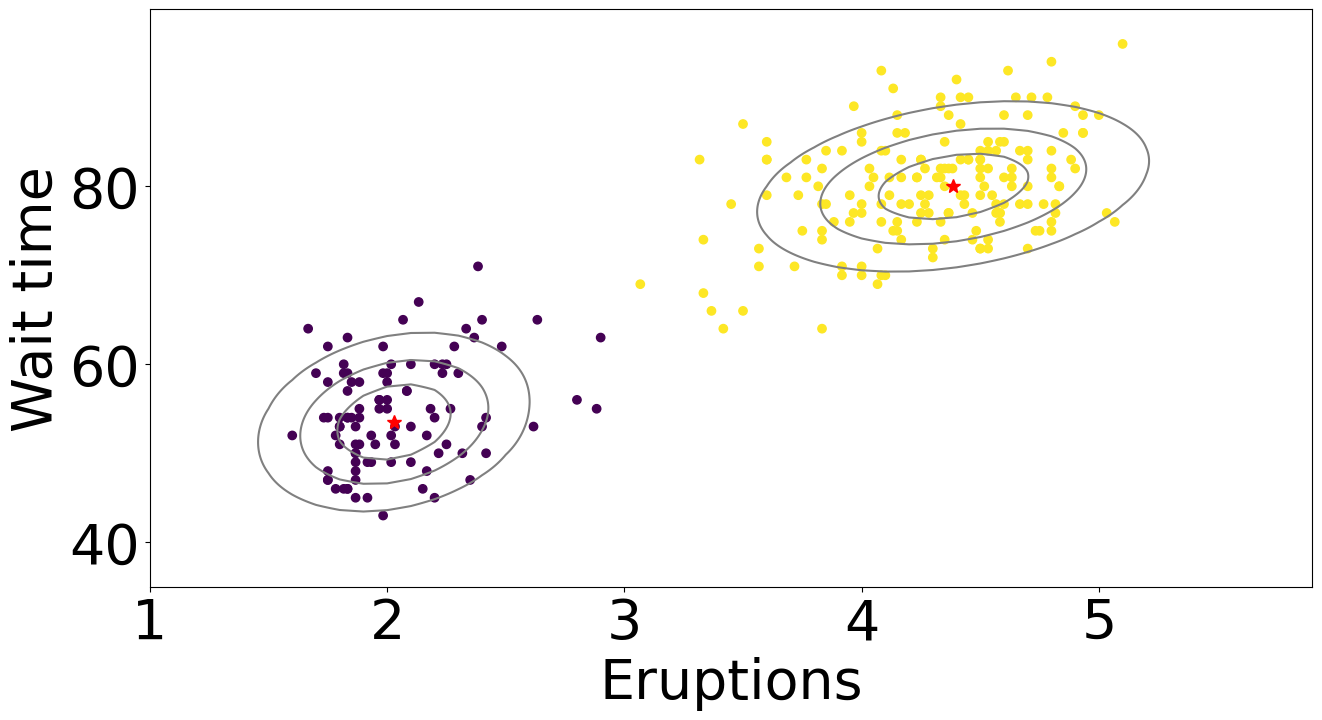

In [27]:
plt.scatter(dat[:,0],dat[:,1],c=np.argmax(lrs,axis=1))
plt.plot(ms[:,0],ms[:,1],'*r',ms=10)

xx, yy = np.mgrid[1:6:.1, 35:100:.1]
data = np.dstack((xx, yy))
for k in range(K):
    rv = stats.multivariate_normal(ms[k,:], invWs[k,:,:]/nus[k])
    zz = rv.pdf(data)
    plt.contour(xx, yy, zz,levels=4,colors='grey')

    
plt.xlabel('Eruptions')
plt.ylabel('Wait time')

### Palmer penguins data set

In [28]:
from palmerpenguins import load_penguins
penguins = load_penguins().dropna()
std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_27776/2807751474.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_27776/2807751474.py:3: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data


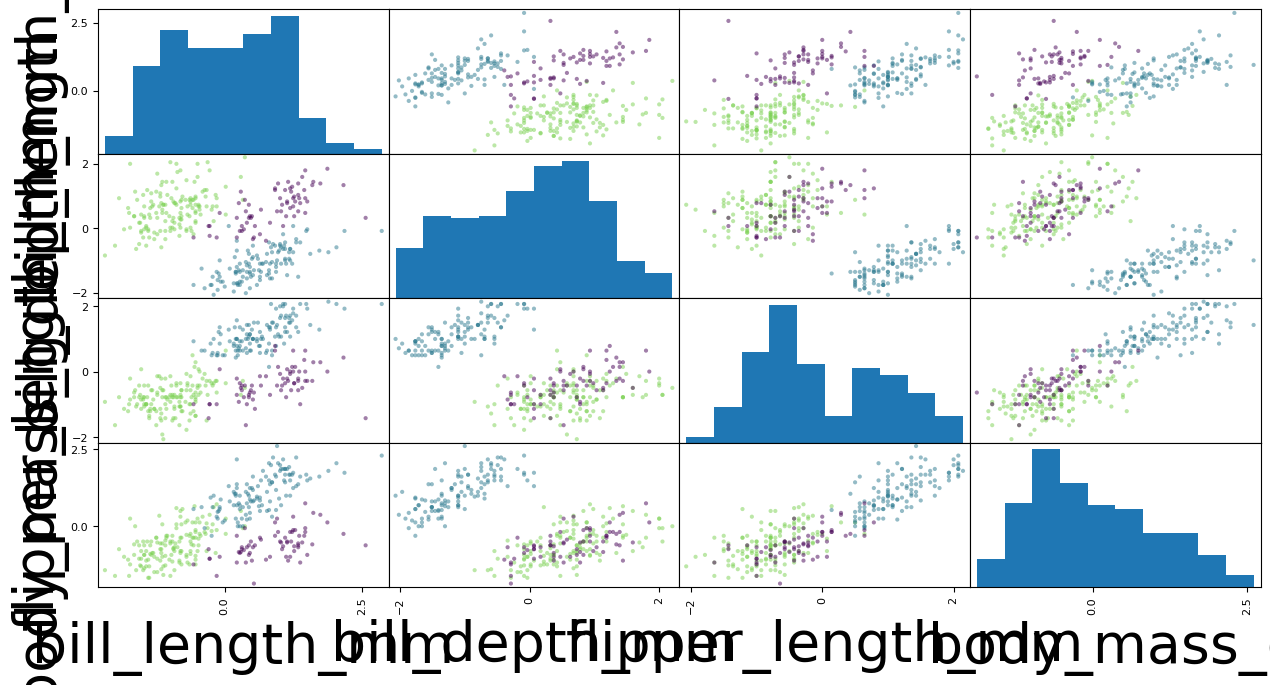

In [29]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[colors=='Adelie']='#7ad151'
colors[colors=='Gentoo']='#2a788e'
colors[colors=='Chinstrap']='#440154'
pd.plotting.scatter_matrix(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [30]:
pg_dat=np.array(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']])

In [31]:
####################
####################
#      setup       #
####################
####################
K=3
y=pg_dat
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,4,4))
for k in range(K): sigma0[k,:,:]=1.*np.eye(4)
iterations=10000

In [32]:
####################
####################
#  run optimizer   #
####################
####################
alphas,lrs,ms,betas,invWs,nus=meanfieldGMM(y,mu0,sigma0,iterations)

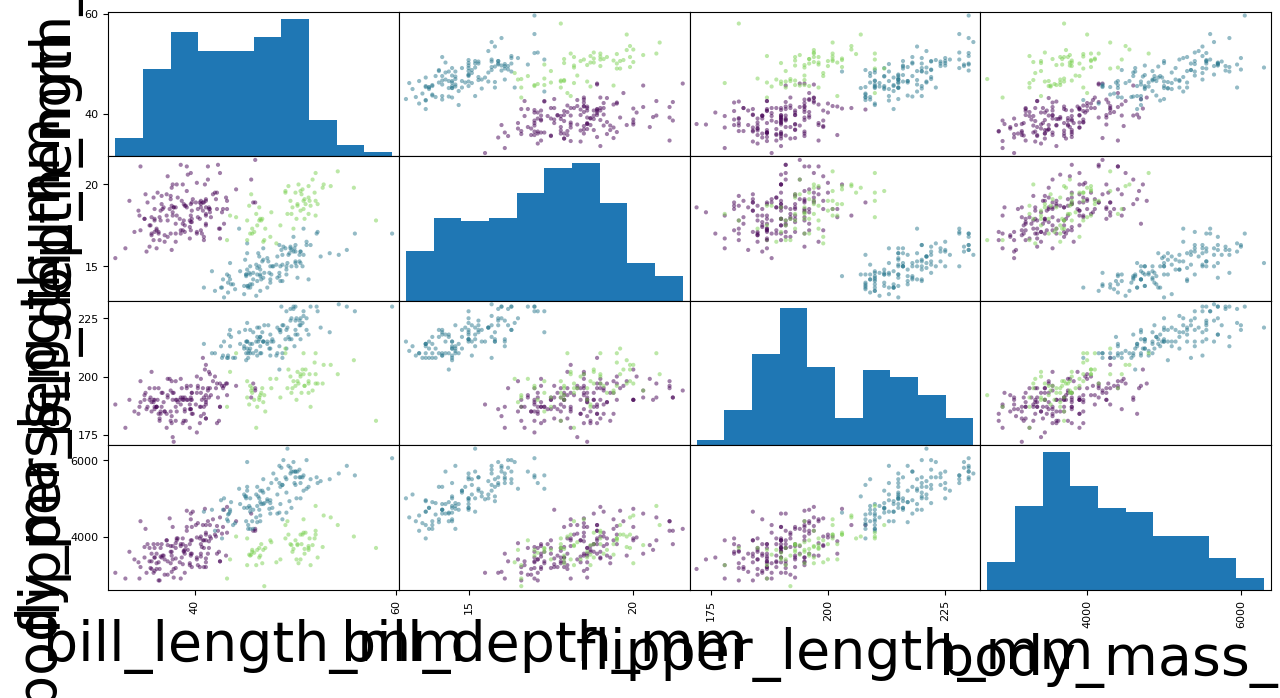

In [33]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[np.argmax(lrs,axis=1)==0]='#440154'
colors[np.argmax(lrs,axis=1)==1]='#7ad151'
colors[np.argmax(lrs,axis=1)==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

### Waveform data

In [34]:
from sklearn.decomposition import PCA
waveform_dat=pd.read_table('https://hastie.su.domains/ElemStatLearn/datasets/waveform.train')
pca = PCA(n_components=4)
pca.fit(waveform_dat[waveform_dat.columns.difference(['row.names','y'])])
waveform_pca=np.array(waveform_dat[waveform_dat.columns.difference(['row.names','y'])])@pca.components_.T
wf_dat=waveform_pca[:,:2]

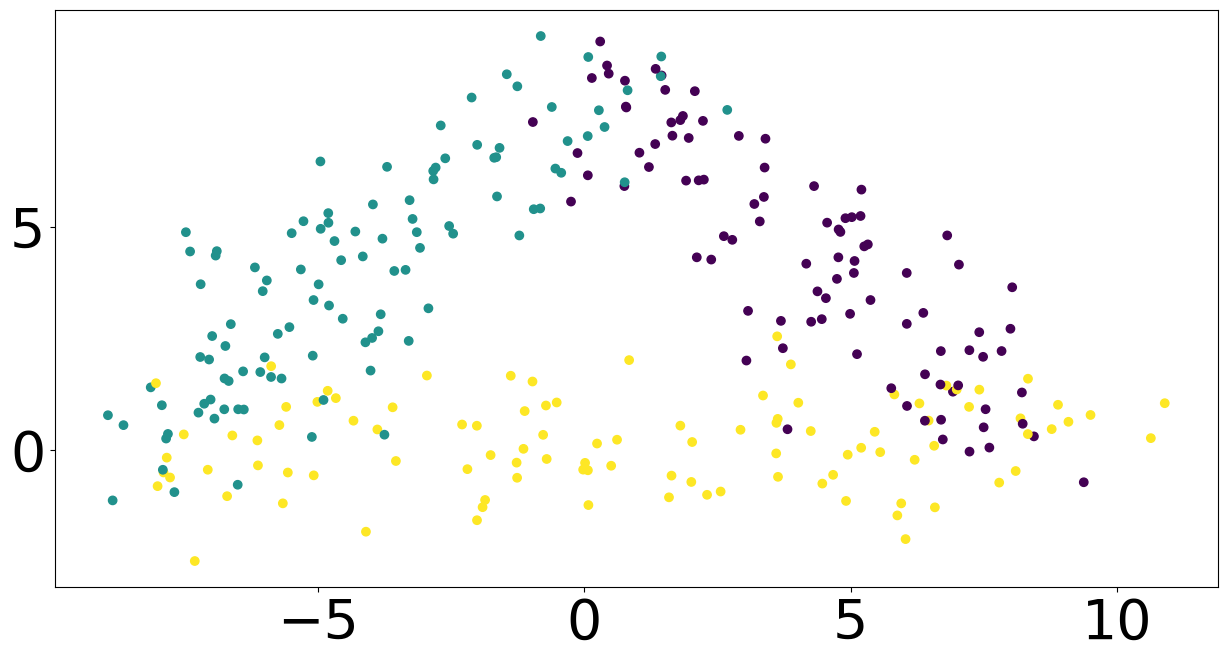

In [35]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.squeeze(np.array(waveform_dat[['y']])))

In [36]:
####################
####################
#      setup       #
####################
####################
K=3
y=wf_dat
# initial arrays
mu0=np.array([[-3.,4.],  # blue
              [ 5.,4.],  # purple 
              [ 0.,0.]]) # yellow
sigma0=np.zeros((K,2,2))
for k in range(K): sigma0[k,:,:]=5.*np.eye(2)
iterations=10000

In [37]:
####################
####################
#  run optimizer   #
####################
####################
alphas,lrs,ms,betas,invWs,nus=meanfieldGMM(y,mu0,sigma0,iterations)

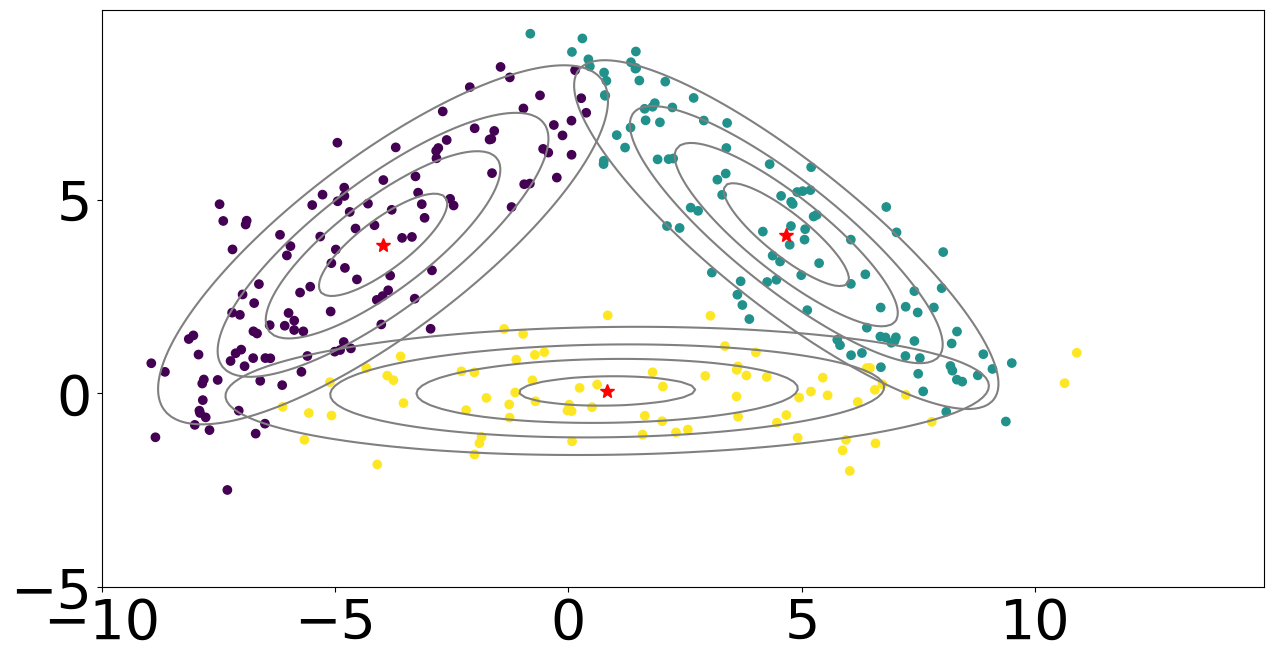

In [38]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.argmax(lrs,axis=1))
plt.plot(ms[:,0],ms[:,1],'*r',ms=10)

xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
for k in range(K):
    rv = stats.multivariate_normal(ms[k,:], invWs[k,:,:]/nus[k])
    zz = rv.pdf(data)
    plt.contour(xx, yy, zz,levels=4,colors='grey')